### ISA 414 Final Project - Stock Predictions through Unsupervised Sentiment Analysis
##### Ethan Buege, Jorge Nadjar, Mac Magyaros

Libraries being used:
- Pandas
- Numpy
- PSAW (Python Pushshift.io API Wrapper)
- PRAW (Python Reddit API Wrapper)
- PyTorch
- sklearn

In [193]:
# standard python libraries
import requests
from requests import auth
import time
from time import sleep
import datetime as dt
from datetime import timezone
import collections
import random
import logging

# data handling
import pandas as pd
import numpy as np
import re
import pickle
import pymongo

# reddit API
import praw
from psaw import PushshiftAPI
from praw.models import MoreComments

# unsupervised sentiment analysis - doc2vec encoding
import gensim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext as tt

# visualization
import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
use_cuda = torch.cuda.is_available()

top_10_tickers = ['GME', 'AMC', 'TSLA', 'AAPL', 'AMZN', 'AMD', 'NVDA', 'MSFT', 'SPY', 'QQQ']

In [153]:
doc2vec_model = pickle.load(open('doc2vec_model.p', "rb"))

In [10]:
def aggregate_posts_by_day(ticker):
    aggregated_daily_posts = {}
    posts = pickle.load(open(f'E:/reddit_data/{ticker}_series.p', "rb"))
    # replace UTC timestamp with date for easy aggregation
    for post in posts:
        day = dt.datetime.utcfromtimestamp(post.created_utc).date()
        delta = day.weekday() - 4
        if delta > 0:  # if day is weekend, aggregate to friday
            days_back = dt.timedelta(delta)
            day -= days_back

        if day not in aggregated_daily_posts:
            aggregated_daily_posts[day] = ''

            # aggregate titles
        if 'deleted by user' not in post.title and len(post.title) > 5:
            aggregated_daily_posts[day] = ' '.join([aggregated_daily_posts[day], post.title])

            # add bodytext if it exists and has not been deleted
            # WSB has minimum length requirements so the only posts less than 20 chars have been deleted
            if len(post.selftext) > 20:
                aggregated_daily_posts[day] = ' '.join([aggregated_daily_posts[day], post.selftext])

    return aggregated_daily_posts


# daily_posts = aggregate_posts_by_day('TSLA')


for ticker in top_10_tickers:
    daily_posts = aggregate_posts_by_day(ticker)
    for day in daily_posts:
        tokens = gensim.utils.simple_preprocess(daily_posts[day])
        daily_posts[day] = doc2vec_model.infer_vector(tokens)

    print(f'aggregated and vectorized {ticker} posts saved to disk')
    pickle.dump(daily_posts, open(f'E:/reddit_data/{ticker}_vectorized_posts.p', "wb"))

aggregated and vectorized GME posts saved to disk
aggregated and vectorized AMC posts saved to disk
aggregated and vectorized TSLA posts saved to disk
aggregated and vectorized AAPL posts saved to disk
aggregated and vectorized AMZN posts saved to disk
aggregated and vectorized AMD posts saved to disk
aggregated and vectorized NVDA posts saved to disk
aggregated and vectorized MSFT posts saved to disk
aggregated and vectorized SPY posts saved to disk
aggregated and vectorized QQQ posts saved to disk


In [154]:
# gme_vectorized_posts = pickle.load(open(f'E:/reddit_data/GME_vectorized_posts.p', "rb"))


# start_date = dt.date(2019, 4, 26)
# print(len(gme_vectorized_posts))
# print(len(tsla_vectorized_posts))

# print(gme_vectorized_posts[start_date])
# print(tsla_vectorized_posts[start_date])


### Addition - Jorge

In [162]:
tsla_vectorized_posts = pickle.load(open(f'E:/reddit_data/TSLA_vectorized_posts.p', "rb"))
tsla_prices = pd.read_csv('TSLA_prices.csv')

,from,open,high,low,close,volume,afterHours,preMarket
0,2017-04-24,61.844,62.110,61.2043,61.606,25417525,61.5460,62.000
1,2017-04-25,61.600,62.796,61.1720,62.758,33688540,62.7500,61.700
2,2017-04-26,62.474,62.900,61.8000,62.034,23475220,62.0020,62.628
3,2017-04-27,62.338,62.618,61.5000,61.726,17342845,61.8200,61.980
4,2017-04-28,61.966,62.960,61.6000,62.814,22527390,62.9200,61.958
...,...,...,...,...,...,...,...,...
1255,2022-04-18,989.030,1014.920,973.4100,1004.290,17237387,1013.0200,987.250
1256,2022-04-19,1005.060,1034.940,995.3250,1028.150,16604744,1018.0000,1008.180
1257,2022-04-20,1030.000,1034.000,975.2501,977.200,23534922,1031.1800,1015.240
1258,2022-04-21,1074.730,1092.220,996.4150,1008.780,35136565,1011.3999,1031.610


In [163]:
keys_values = tsla_vectorized_posts.items()
tsla_posts_string = {key.strftime('%Y-%m-%d'): value for key, value in keys_values}
tsla_prices['Doc Vector'] = tsla_prices['from'].map(tsla_posts_string)

In [102]:
print(tsla_prices['Doc Vector'].isna().sum())
tsla_prices
# tsla_prices['Doc Vector'] = tsla_prices['Doc Vector'].fillna(np.array([0] * 300))
# print(tsla_prices['Doc Vector'].isna().sum())

142


,from,open,high,low,close,volume,afterHours,preMarket,Doc Vector
0,2017-04-24,61.844,62.110,61.2043,61.606,25417525,61.5460,62.000,"[0.040901948, 0.13189691, 0.21032988, 0.517476..."
1,2017-04-25,61.600,62.796,61.1720,62.758,33688540,62.7500,61.700,NaN
2,2017-04-26,62.474,62.900,61.8000,62.034,23475220,62.0020,62.628,NaN
3,2017-04-27,62.338,62.618,61.5000,61.726,17342845,61.8200,61.980,"[3.1744103, -0.71836853, 0.29069683, -1.844398..."
4,2017-04-28,61.966,62.960,61.6000,62.814,22527390,62.9200,61.958,NaN
...,...,...,...,...,...,...,...,...,...
1255,2022-04-18,989.030,1014.920,973.4100,1004.290,17237387,1013.0200,987.250,NaN
1256,2022-04-19,1005.060,1034.940,995.3250,1028.150,16604744,1018.0000,1008.180,NaN
1257,2022-04-20,1030.000,1034.000,975.2501,977.200,23534922,1031.1800,1015.240,NaN
1258,2022-04-21,1074.730,1092.220,996.4150,1008.780,35136565,1011.3999,1031.610,NaN


In [164]:
price = tsla_prices[['close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['close'] = scaler.fit_transform(price['close'].values.reshape(-1, 1))
print(price)

         close
0    -0.956768
1    -0.954839
2    -0.956051
3    -0.956567
4    -0.954745
...        ...
1255  0.622114
1256  0.662076
1257  0.576741
1258  0.629634
1259  0.623387

[1260 rows x 1 columns]


C:\Users\admin\AppData\Local\Temp/ipykernel_19972/3451838763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['close'] = scaler.fit_transform(price['close'].values.reshape(-1, 1))


In [165]:
n = len(price)
price_list = price['close'].tolist()
docscaler = MinMaxScaler(feature_range=(-1, 1))

docvecs = tsla_prices['Doc Vector'].to_numpy()
minval, maxval = 0, 0
for i in range(n):
    if not isinstance(docvecs[i], (list,pd.Series,np.ndarray)):
        docvecs[i] = np.zeros(300)
    else:
        # note: this method of normalization likely loses some data since it is refit for every sample
        # but I didn't have enough time left to do something more thorough
        docvecs[i] = docscaler.fit_transform(docvecs[i].reshape(-1, 1)).reshape(300,)

# docvecs = docvecs.reshape(1260, 300)
docvecs = docvecs.tolist()
docvecs = np.array(docvecs)
print(docvecs.shape)
print(docvecs[0])
print(docvecs[1])



(1260, 300)
[-1.75638944e-02  3.87618691e-02  8.73117596e-02  2.77435154e-01
 -8.11077431e-02 -6.50198981e-02  1.85869813e-01  4.18952614e-01
  6.43534437e-02 -3.21677104e-02 -3.06952558e-02 -2.22989798e-01
  3.41111571e-01  1.06559888e-01 -3.42815556e-02 -4.85008925e-01
  4.27968323e-01  2.46909201e-01 -4.79804307e-01  1.47895701e-02
 -5.55715978e-01 -6.03959739e-01  6.53218627e-01 -5.32940030e-01
  1.00000000e+00  4.40795124e-01 -1.91278353e-01 -1.62204176e-01
 -1.08288251e-01 -1.82405055e-01  5.84190667e-01 -4.96096879e-01
  4.49462116e-01  3.00554186e-01 -1.55929387e-01  6.68176293e-01
 -5.04411817e-01  2.54654020e-01  1.46798998e-01 -7.91576281e-02
 -2.11259022e-01 -5.61412096e-01 -3.83153945e-01 -2.72830665e-01
 -2.34086849e-02 -3.47140104e-01 -1.33050099e-01 -2.01050565e-01
  4.55972850e-01 -1.49987880e-02  4.60443497e-02  9.75347310e-03
  5.41220725e-01  3.33425075e-01 -3.89875621e-01 -4.34798956e-01
 -3.70391980e-02 -2.43550315e-01  2.05387652e-01  2.46884286e-01
  4.89583611e

In [167]:
x = np.concatenate((price, docvecs), axis=1)
print(len(x[0]))
print(x[0])


301
[-9.56768019e-01 -1.75638944e-02  3.87618691e-02  8.73117596e-02
  2.77435154e-01 -8.11077431e-02 -6.50198981e-02  1.85869813e-01
  4.18952614e-01  6.43534437e-02 -3.21677104e-02 -3.06952558e-02
 -2.22989798e-01  3.41111571e-01  1.06559888e-01 -3.42815556e-02
 -4.85008925e-01  4.27968323e-01  2.46909201e-01 -4.79804307e-01
  1.47895701e-02 -5.55715978e-01 -6.03959739e-01  6.53218627e-01
 -5.32940030e-01  1.00000000e+00  4.40795124e-01 -1.91278353e-01
 -1.62204176e-01 -1.08288251e-01 -1.82405055e-01  5.84190667e-01
 -4.96096879e-01  4.49462116e-01  3.00554186e-01 -1.55929387e-01
  6.68176293e-01 -5.04411817e-01  2.54654020e-01  1.46798998e-01
 -7.91576281e-02 -2.11259022e-01 -5.61412096e-01 -3.83153945e-01
 -2.72830665e-01 -2.34086849e-02 -3.47140104e-01 -1.33050099e-01
 -2.01050565e-01  4.55972850e-01 -1.49987880e-02  4.60443497e-02
  9.75347310e-03  5.41220725e-01  3.33425075e-01 -3.89875621e-01
 -4.34798956e-01 -3.70391980e-02 -2.43550315e-01  2.05387652e-01
  2.46884286e-01  4.8

Slice data and construct training/test sets

IDEA: convert UTC timestamp to date first, then aggregate

also test with sentiment api data

In [169]:
def split_data(stock, lookback):
    data_raw = np.array(stock)  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :1]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :1]

    return [x_train, y_train, x_test, y_test]


lookback = 10  # choose sequence length
x_train, y_train, x_test, y_test = split_data(x, lookback)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
# y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
# y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape =  (1000, 9, 301)
y_train.shape =  (1000, 1)
x_test.shape =  (250, 9, 301)
y_test.shape =  (250, 1)


In [ ]:
y_train_categorical = [int(y_train_lstm[i]) for i in range(len(y_train_lstm))]


Define model architecture

In [189]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [190]:
input_dim = 301
hidden_dim = 128
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

Train model over 100 epochs

In [191]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.7060477137565613
Epoch  1 MSE:  0.08226928114891052
Epoch  2 MSE:  0.5204430222511292
Epoch  3 MSE:  1.0688422918319702
Epoch  4 MSE:  0.6677717566490173
Epoch  5 MSE:  0.4177211821079254
Epoch  6 MSE:  0.20421500504016876
Epoch  7 MSE:  0.20761975646018982
Epoch  8 MSE:  0.1650606393814087
Epoch  9 MSE:  0.0861530601978302
Epoch  10 MSE:  0.08510740846395493
Epoch  11 MSE:  0.09034072607755661
Epoch  12 MSE:  0.07702551037073135
Epoch  13 MSE:  0.05274895578622818
Epoch  14 MSE:  0.03360177204012871
Epoch  15 MSE:  0.029439013451337814
Epoch  16 MSE:  0.034374527633190155
Epoch  17 MSE:  0.03317828103899956
Epoch  18 MSE:  0.023792611435055733
Epoch  19 MSE:  0.015795137733221054
Epoch  20 MSE:  0.014895669184625149
Epoch  21 MSE:  0.018397174775600433
Epoch  22 MSE:  0.020424751564860344
Epoch  23 MSE:  0.018280507996678352
Epoch  24 MSE:  0.01354143489152193
Epoch  25 MSE:  0.009475587867200375
Epoch  26 MSE:  0.008231721818447113
Epoch  27 MSE:  0.00939625781029462

Evaluate training and test accuracy


Test MSE:  0.7567235827445984
[[  61.438]
 [  64.252]
 [  65.044]
 ...
 [ 977.2  ]
 [1008.78 ]
 [1005.05 ]]


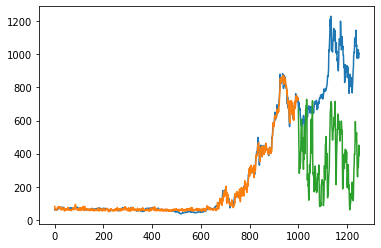

In [192]:
y_train_pred = model(x_train)  # forward
y_test_pred = model(x_test)

test_loss = criterion(y_test_pred, y_test_lstm)
print("Test MSE: ", test_loss.item())

y_train_unscaled = scaler.inverse_transform(y_train_pred.tolist())
y_test_unscaled = scaler.inverse_transform(y_test_pred.tolist())

# y_all_pred = y_train_pred + y_test_pred
y_gt = tsla_prices[['close']].to_numpy()[lookback:]
print(y_gt)
x_axis = range(len(y_train_pred))

# print(max(y_all_pred))
# unscaled_pred = scaler.inverse_transform(y_all_pred)
# print(max(unscaled_pred))
train_len = len(y_train_unscaled)
test_len = len(y_test_unscaled)

plt.plot(range(len(y_gt)), y_gt)
plt.plot(range(train_len), y_train_unscaled)
plt.plot(range(train_len, train_len + test_len), y_test_unscaled)

# plt.plot(range(test_len), y_gt[train_len:])
# plt.plot(range(test_len), y_test_unscaled)

plt.show()
